## Task 1--Sentiment Analysis

In [ ]:
import pandas as pd
from data import AShareData, NewsData
from model import BertWrapper, LogisticRegressor
from utils import Task1_output
import matplotlib.pyplot as plt

In [2]:
A_share_data = AShareData(data_dir="../Data/A-share_list.json")
news_data = NewsData(data_dir="../Data/News.xlsx")

In [3]:
name_list = A_share_data.getNameList

### Easily using force brute search on news data

In [4]:
clean_data, noise_data = news_data.force_denoise(name_list=name_list)

In [5]:
# After the brute force search, we can get the data with explicit A-share company name
name_list = A_share_data.getNameList
companyName_dict = news_data.Explicit_Company_list(name_list)
companyName_dict_df = pd.Series(companyName_dict, name = "Explicit_Company")
companyName_dict_df.to_csv("../Data/name.csv", index=False)

In [6]:
clean_data.to_csv("../Data/clean_data.csv")
print(clean_data.shape)
clean_data.head()

(473199, 5)


,NewsID,Title,NewsContent,NewsSource,text
0,1,建设银行原董事长张恩照一审被判15年,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,中国证券报,建设银行原董事长张恩照一审被判15年. 本报记者 田雨 李京华 中国建设银行股份...
1,2,农行信用卡中心搬到上海滩,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,人民日报,农行信用卡中心搬到上海滩. 中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生...
2,3,外运发展：价值型蓝筹股补涨要求强烈,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,杭州新希望,外运发展：价值型蓝筹股补涨要求强烈. 在新基金快速发行以及申购资金回流的情况下，市场总体上...
3,4,胜利股份：稳步走强形成标准上升通道,胜利股份（000407）公司子公司填海造地2800亩，以青岛的地价估算，静态价值在10亿...,源达投资,胜利股份：稳步走强形成标准上升通道. 胜利股份（000407）公司子公司填海造地2800亩...
7,8,"南风化工：钾肥三雄之一 被""中化""相中",由于全球最大的俄罗斯Uralkaly钾矿被淹，产量大减，同时满洲里口岸铁路在修复线，导致...,银河证券,"南风化工：钾肥三雄之一 被""中化""相中. 由于全球最大的俄罗斯Uralkaly钾矿被淹，产..."


### Pretrained Bert-Model(hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2)
https://huggingface.co/hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2
- **Great for Chinese Financial News sentiment analysis**
- **Label the data using LLM can reduce a lot of time**

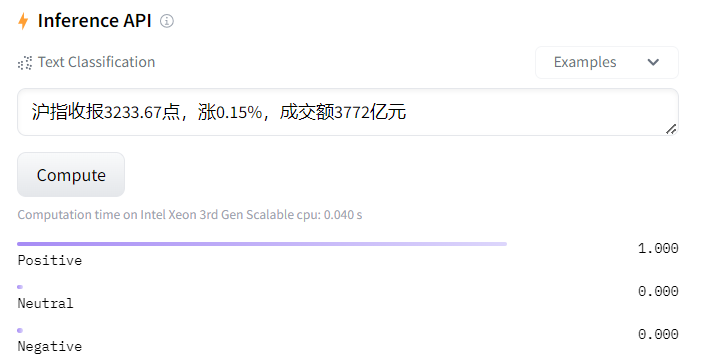

In [7]:
Bert = BertWrapper("../checkpoints")
outputs = Bert.predict(batch_size=4, dataPath="../Data/clean_data.csv")

Begin Training!


In [8]:
labels = Bert.convert_label(outputs=outputs)
labels.shape

========> label: Negative: 0; Postive: 1


(473199,)

In [9]:
Task1_df = Task1_output(Bert.dataset, labels)

### Coarse to Fine
- **Bert_Tokenizer for Text representation**

- **Simple three layers MLP**

#### Step1: Find the uncertainty and certainty data

In [10]:
sure_row_indices, unsure_row_indices = Bert.select_by_certainty(outputs, threshold=0.6)

In [11]:
train_df = Task1_df.iloc[sure_row_indices, :]
test_df = Task1_df.iloc[unsure_row_indices, :]

In [12]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

#### Step2: Train a simple MLP model on certainty label given by the LLM

In [13]:
logisticRegressor = LogisticRegressor()
logisticRegressor.train(dataframe=train_df, epochs=2, batch_size=16)

====>Begin Training!


====>Stop Training


#### Step3: ReLabel the uncertainty label given by the LLM using the MLP model

In [14]:
predict_label = logisticRegressor.predict(test_df)

### Save the result

In [21]:
Task1_df

,NewsID,NewsContent,Explicit_Company,label
0,1,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,['建设银行'],0
1,2,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,['农业银行'],1
2,3,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,"['外运发展', '中国国航']",1
3,4,胜利股份（000407）公司子公司填海造地2800亩，以青岛的地价估算，静态价值在10亿...,['胜利股份'],1
4,8,由于全球最大的俄罗斯Uralkaly钾矿被淹，产量大减，同时满洲里口岸铁路在修复线，导致...,['冠农股份'],1
...,...,...,...,...
473194,1037031,每经AI快讯，有投资者在投资者互动平台提问：请问公司目前有没有电解槽产能，规划情况能否详细介...,['亿华通'],1
473195,1037032,依米康（SZ 300249，收盘价：10.38元）发布公告称，2023年10月12日，依米康...,"['中泰证券', '依米康']",1
473196,1037033,天风证券10月13日发布研报称，给予中核科技（000777.SZ，最新价：13.03元）买入...,"['中核科技', '天风证券']",1
473197,1037034,有投资者提问：抗癌药CPT获批后，公司是否应该按照股权协议继续收购沙东股权，适应症为MM的C...,['海特生物'],1


========> label: Negative: 0; Postive: 1

In [2]:
Task1_df.iloc[:, 1:].to_excel("../Data/Task1.xlsx", index=False)

In [3]:
pd.read_excel("../Data/Task1.xlsx")

,NewsID,NewsContent,Explicit_Company,label
0,1,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,建设银行,0
1,2,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,农业银行,1
2,3,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,"外运发展, 中国国航",1
3,4,胜利股份（000407）公司子公司填海造地2800亩，以青岛的地价估算，静态价值在10亿...,胜利股份,1
4,8,由于全球最大的俄罗斯Uralkaly钾矿被淹，产量大减，同时满洲里口岸铁路在修复线，导致...,冠农股份,1
...,...,...,...,...
473194,1037031,每经AI快讯，有投资者在投资者互动平台提问：请问公司目前有没有电解槽产能，规划情况能否详细介...,亿华通,1
473195,1037032,依米康（SZ 300249，收盘价：10.38元）发布公告称，2023年10月12日，依米康...,"中泰证券, 依米康",1
473196,1037033,天风证券10月13日发布研报称，给予中核科技（000777.SZ，最新价：13.03元）买入...,"中核科技, 天风证券",1
473197,1037034,有投资者提问：抗癌药CPT获批后，公司是否应该按照股权协议继续收购沙东股权，适应症为MM的C...,海特生物,1
